Is there a significant difference between critics’ and audience ratings across genres?

In [515]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import seaborn as sns
import ast
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from collections import Counter

In [443]:
df = pd.read_csv("processed.csv")

In [444]:
df.head()

,Unnamed: 0,movie_id,title,release_date,budget,revenue_worldwide,runtime,genres,imdb_id,franchise,...,imdb_votes,mpaa_rating,domestic_box_office,rotten_tomatoes_score,metacritic_score,awards_text,month,season,critics_score,audience_score
0,0,8193,Napoleon Dynamite,2004-06-11,-0.731466,46118097,95,['Comedy'],tt0374900,False,...,251071.0,PG,44540956.0,72.0,64.0,10 wins & 23 nominations total,6,Summer,6.80,0.70
1,1,663558,New Gods: Nezha Reborn,2021-02-06,-0.737418,70000000,117,"['Animation', 'Fantasy', 'Action']",tt13269670,True,...,4451.0,TV-14,NaN,80.0,NaN,3 wins & 3 nominations total,2,Winter,8.00,0.68
2,2,614409,To All the Boys: Always and Forever,2021-02-12,-0.737418,0,115,"['Romance', 'Comedy', 'Drama']",tt10676012,True,...,37385.0,TV-14,NaN,79.0,65.0,2 wins & 2 nominations total,2,Winter,7.20,0.63
3,3,12,Finding Nemo,2003-05-30,0.661406,940335536,100,"['Animation', 'Family']",tt0266543,True,...,1185437.0,G,380843261.0,99.0,90.0,Won 1 Oscar. 49 wins & 63 nominations total,5,Other,9.45,0.82
4,4,16,Dancer in the Dark,2000-09-01,-0.551404,40061153,140,"['Drama', 'Crime']",tt0168629,False,...,122419.0,R,4184036.0,69.0,63.0,Nominated for 1 Oscar. 34 wins & 48 nomination...,9,Other,6.60,0.79


In [445]:
df.columns

Index(['Unnamed: 0', 'movie_id', 'title', 'release_date', 'budget',
       'revenue_worldwide', 'runtime', 'genres', 'imdb_id', 'franchise',
       'cast_popularity_mean', 'cast_popularity_max', 'director_popularity',
       'original_language', 'imdb_rating', 'imdb_votes', 'mpaa_rating',
       'domestic_box_office', 'rotten_tomatoes_score', 'metacritic_score',
       'awards_text', 'month', 'season', 'critics_score', 'audience_score'],
      dtype='object')

In [446]:
df.dtypes

,0
Unnamed: 0,int64
movie_id,int64
title,object
release_date,object
budget,float64
revenue_worldwide,int64
runtime,int64
genres,object
imdb_id,object
franchise,bool


In [447]:
features = df[['critics_score','audience_score','genres']].copy()

features = features.dropna(subset=['critics_score','audience_score'])

import ast
features['genres'] = features['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)


In [448]:
features["genres"]

,genres
0,[Comedy]
1,"[Animation, Fantasy, Action]"
2,"[Romance, Comedy, Drama]"
3,"[Animation, Family]"
4,"[Drama, Crime]"
...,...
790,"[Thriller, Horror]"
791,"[Thriller, Drama, Crime]"
792,"[Drama, Animation, Family, Comedy]"
793,"[Mystery, Romance, Science Fiction]"


In [449]:
X = features[['critics_score','audience_score']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [450]:
X_scaled

array([[ 0.40137378,  0.37946299],
       [ 0.94559607,  0.1722651 ],
       [ 0.58278121, -0.34572962],
       ...,
       [ 0.99094793,  0.48306193],
       [-0.73242265,  0.27586405],
       [-0.66439486,  0.69025982]])

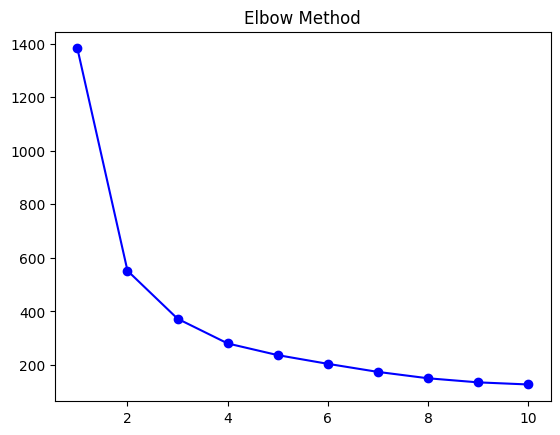

In [451]:
inertia = []
K_range = range(1,11)
K_range = range(1,11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(K_range, inertia, 'bo-')
plt.title('Elbow Method')
plt.show()

In [452]:
kmeans = KMeans(n_clusters=4, random_state=42)
features['cluster'] = kmeans.fit_predict(X_scaled)

cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster centers (critics_score, audience_score):")
print(cluster_centers)


Cluster centers (critics_score, audience_score):
[[6.75693069 0.67465347]
 [8.29557292 0.77244792]
 [4.34553991 0.61812207]
 [2.42857143 0.50166667]]


In [453]:
cluster_names = []
print(" Analyzing 4 Clusters ")

for i, c in enumerate(cluster_centers):
    critics_val = c[0]
    audience_val = c[1] * 10

    diff = audience_val - critics_val
    avg = (critics_val + audience_val) / 2

    name = ""


    if avg < 5.0:
        name = 'Consensus: Poor Quality'

    elif diff > 1.0:
        name = 'Divergence: Audience Preferred'

    elif diff < -1.0:
        name = 'Divergence: Critics Preferred'

    elif avg > 7.5:
        name = 'Consensus: High Quality'

    else:
        name = 'Consensus: Average'

    cluster_names.append(name)
    print(f"Cluster {i}: Crit={critics_val:.1f}, Aud={audience_val:.1f}, Diff={diff:.1f} -> {name}")

cluster_map = {i:name for i,name in enumerate(cluster_names)}
features['cluster_name'] = features['cluster'].map(cluster_map)


 Analyzing 4 Clusters 
Cluster 0: Crit=6.8, Aud=6.7, Diff=-0.0 -> Consensus: Average
Cluster 1: Crit=8.3, Aud=7.7, Diff=-0.6 -> Consensus: High Quality
Cluster 2: Crit=4.3, Aud=6.2, Diff=1.8 -> Divergence: Audience Preferred
Cluster 3: Crit=2.4, Aud=5.0, Diff=2.6 -> Consensus: Poor Quality


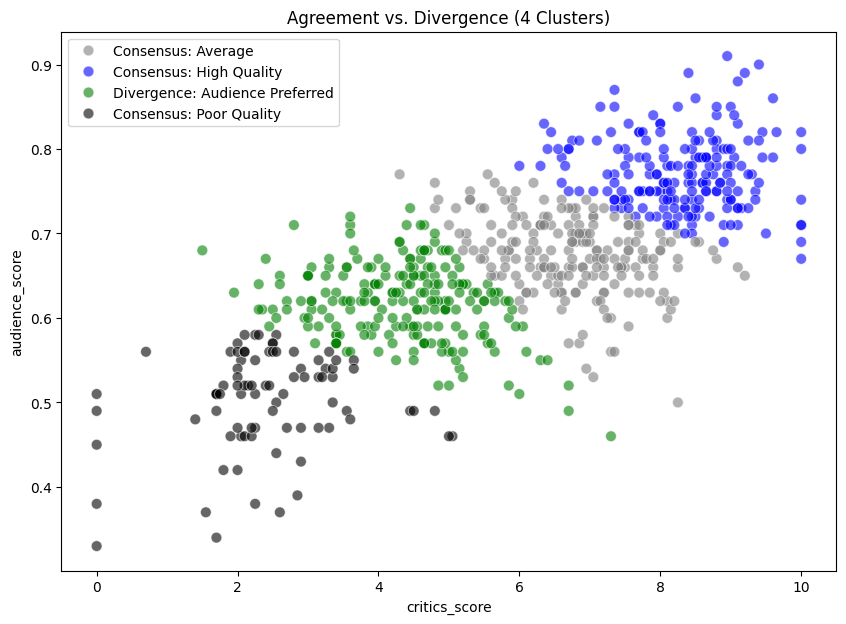

In [454]:
colors = {
    'Consensus: High Quality': 'blue',
    'Consensus: Poor Quality': 'black',
    'Divergence: Audience Preferred': 'green',
    'Divergence: Critics Preferred': 'red',
    'Consensus: Average': 'gray'
}

plt.figure(figsize=(10,7))
sns.scatterplot(
    x='critics_score', y='audience_score',
    hue='cluster_name', palette=colors,
    data=features, alpha=0.6, s=60
)
plt.title('Agreement vs. Divergence (4 Clusters)')
plt.legend()
plt.show()

In [455]:
df['genres'].value_counts()

,count
genres,
['Drama'],30
['Comedy'],30
"['Drama', 'Romance']",27
"['Comedy', 'Romance']",23
"['Comedy', 'Drama']",15
...,...
"['Adventure', 'Comedy', 'Crime']",1
"['Adventure', 'Fantasy', 'Drama']",1
"['Horror', 'Thriller', 'Mystery']",1


In [472]:
features_exploded = features.explode('genres')

genre_cluster_distribution = (
    features_exploded.groupby(['genres', 'cluster_name'])
    .size()
    .unstack(fill_value=0)
)

In [473]:
genre_cluster_distribution = (
    features_exploded.groupby(['genres', 'cluster_name'])
    .size()
    .unstack(fill_value=0)
)


In [457]:
genre_cluster_distribution['total'] = genre_cluster_distribution.sum(axis=1)

expected_cols = [
    'Consensus: High Quality',
    'Consensus: Poor Quality',
    'Divergence: Audience Preferred',
    'Divergence: Critics Preferred',
    'Consensus: Average'
]

for col in expected_cols:
    if col in genre_cluster_distribution.columns:
        genre_cluster_distribution[col+'_pct'] = (genre_cluster_distribution[col] / genre_cluster_distribution['total']) * 100
    else:
        genre_cluster_distribution[col+'_pct'] = 0

print(genre_cluster_distribution.head())

cluster_name  Consensus: Average  Consensus: High Quality  \
genres                                                      
Action                        87                       47   
Adventure                     74                       47   
Animation                     34                       31   
Comedy                       100                       32   
Crime                         47                       28   

cluster_name  Consensus: Poor Quality  Divergence: Audience Preferred  total  \
genres                                                                         
Action                             26                              56    216   
Adventure                          22                              39    182   
Animation                           3                              13     81   
Comedy                             38                              52    222   
Crime                              10                              23    108   

cluster_nam

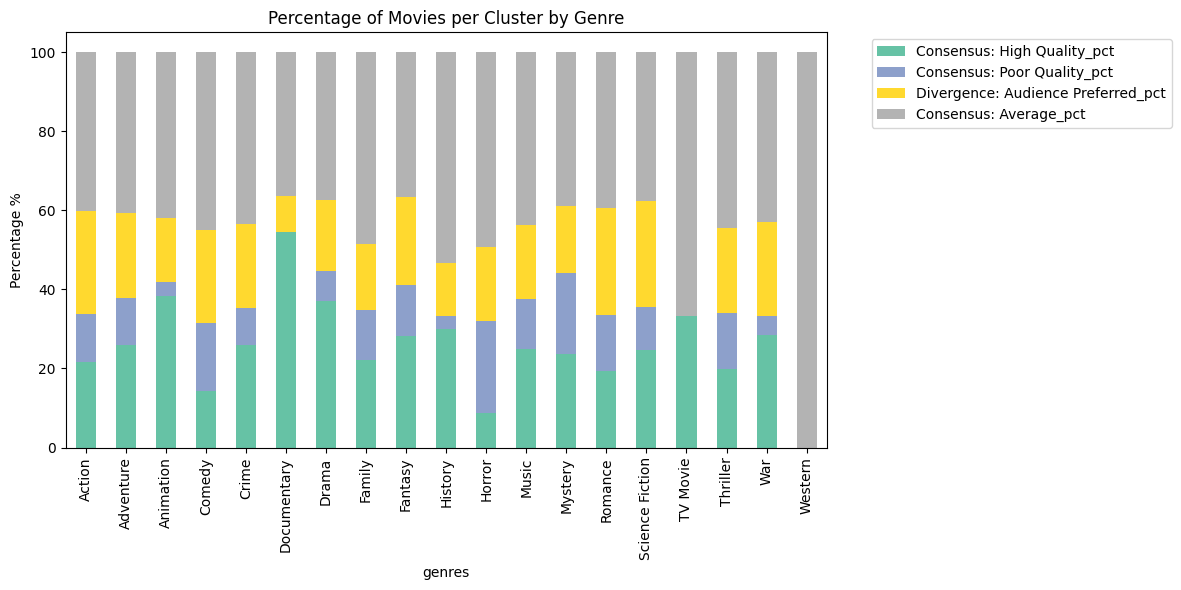

In [458]:
cols_to_plot = [c+'_pct' for c in expected_cols if c in genre_cluster_distribution.columns]

genre_cluster_distribution[cols_to_plot].plot(
    kind='bar',
    stacked=True,
    figsize=(12,6),
    colormap='Set2'
)

plt.title('Percentage of Movies per Cluster by Genre')
plt.ylabel('Percentage %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [459]:
r2_critics = r2_score(features['critics_score'], cluster_centers[features['cluster'],0])
r2_audience = r2_score(features['audience_score'], cluster_centers[features['cluster'],1])

print(f"R² for critics_score: {r2_critics:.3f}")
print(f"R² for audience_score: {r2_audience:.3f}")


R² for critics_score: 0.827
R² for audience_score: 0.768


-------------------------------------

In [493]:
scaler = MinMaxScaler(feature_range=(0, 10))
X_normalized = scaler.fit_transform(features[['critics_score', 'audience_score']])

In [504]:
hc = AgglomerativeClustering(n_clusters=4, linkage='ward')
features['cluster'] = hc.fit_predict(X_normalized)

In [505]:
cluster_centers_scaled = []
for i in range(4):
    cluster_centers_scaled.append(X_scaled[features['cluster']==i].mean(axis=0))
cluster_centers_scaled = np.array(cluster_centers_scaled)
cluster_centers = scaler.inverse_transform(cluster_centers_scaled)

In [514]:
cluster_centers = []
for i in range(4):
    cluster_centers.append(X_normalized[features['cluster'] == i].mean(axis=0))

raw_names = []
print("Analyzing Cluster Centers:")

for i, c in enumerate(cluster_centers):
    critics_val = c[0]
    audience_val = c[1]

    diff = audience_val - critics_val
    avg = (critics_val + audience_val) / 2

    name = "Consensus: Average"

    if avg < 4.8:
        name = 'Consensus: Poor Quality'
    elif diff > 1.2:
        name = 'Divergence: Audience Preferred'
    elif diff < -1.2:
        name = 'Divergence: Critics Preferred'
    elif avg > 7.5:
        name = 'Consensus: High Quality'

    raw_names.append(name)
    print(f"   Cluster {i}: Crit={critics_val:.1f}, Aud={audience_val:.1f} -> Initial Name: {name}")

Analyzing Cluster Centers:
   Cluster 0: Crit=6.5, Aud=5.8 -> Initial Name: Consensus: Average
   Cluster 1: Crit=4.4, Aud=4.9 -> Initial Name: Consensus: Poor Quality
   Cluster 2: Crit=8.2, Aud=7.5 -> Initial Name: Consensus: High Quality
   Cluster 3: Crit=2.4, Aud=3.1 -> Initial Name: Consensus: Poor Quality


In [510]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from collections import Counter

cluster_centers = []
for i in range(4):
    cluster_centers.append(X_normalized[features['cluster'] == i].mean(axis=0))

raw_names = []
print("Analyzing Cluster Centers:")
for i, c in enumerate(cluster_centers):
    critics_val = c[0]
    audience_val = c[1]
    diff = audience_val - critics_val
    avg = (critics_val + audience_val) / 2

    name = "Consensus: Average"

    if avg < 4.8:
        name = 'Consensus: Poor Quality'
    elif diff > 1.2:
        name = 'Divergence: Audience Preferred'
    elif diff < -1.2:
        name = 'Divergence: Critics Preferred'
    elif avg > 7.5:
        name = 'Consensus: High Quality'

    raw_names.append(name)
    print(f"   Cluster {i}: Crit={critics_val:.1f}, Aud={audience_val:.1f} -> Initial Name: {name}")


counts = Counter(raw_names)
final_names = []
seen_counts = {name: 0 for name in counts}

for name in raw_names:
    if counts[name] > 1:
        seen_counts[name] += 1
        new_name = f"{name} (Type {seen_counts[name]})"
        final_names.append(new_name)
    else:
        final_names.append(name)

cluster_map = {i:name for i, name in enumerate(final_names)}
features['cluster_name'] = features['cluster'].map(cluster_map)


Analyzing Cluster Centers:
   Cluster 0: Crit=6.5, Aud=5.8 -> Initial Name: Consensus: Average
   Cluster 1: Crit=4.4, Aud=4.9 -> Initial Name: Consensus: Poor Quality
   Cluster 2: Crit=8.2, Aud=7.5 -> Initial Name: Consensus: High Quality
   Cluster 3: Crit=2.4, Aud=3.1 -> Initial Name: Consensus: Poor Quality


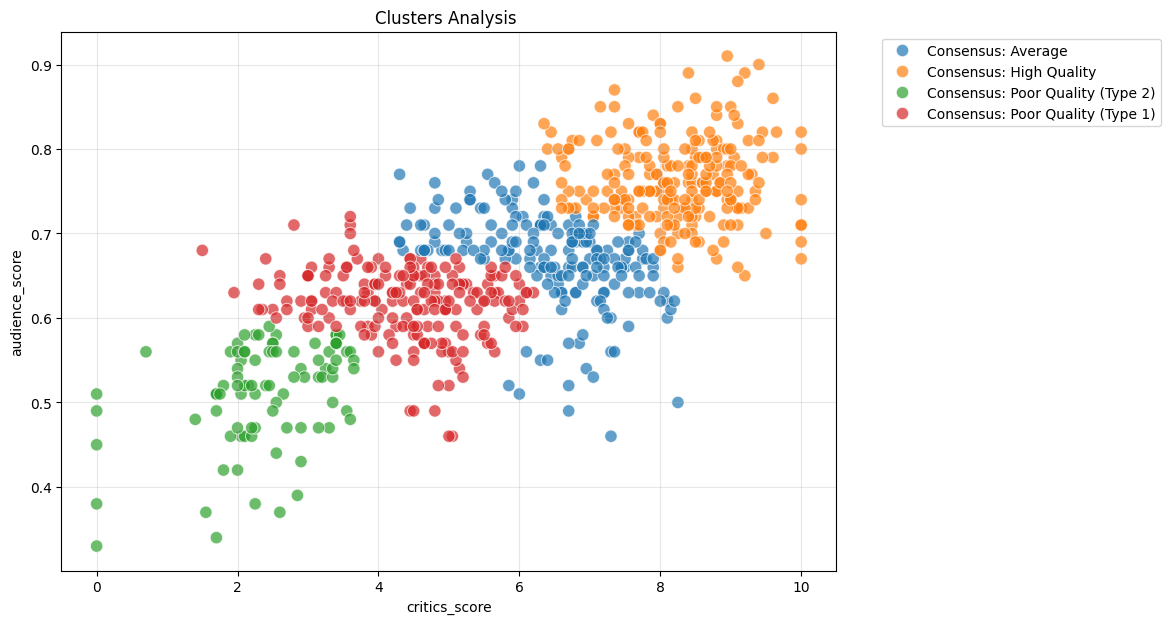

In [516]:
plt.figure(figsize=(10,7))
palette_colors = sns.color_palette("tab10", n_colors=4)

sns.scatterplot(
    x='critics_score', y='audience_score',
    hue='cluster_name',
    palette=palette_colors,
    data=features, alpha=0.7, s=80
)
plt.title('Clusters Analysis ')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()


Corrected Ward Distribution (Look at the Index!):
cluster_name  Consensus: Average  Consensus: High Quality  \
genres                                                      
Action                        59                       62   
Adventure                     52                       57   
Animation                     21                       40   
Comedy                        64                       48   
Crime                         27                       36   

cluster_name  Consensus: Poor Quality (Type 1)  \
genres                                           
Action                                      69   
Adventure                                   52   
Animation                                   17   
Comedy                                      70   
Crime                                       35   

cluster_name  Consensus: Poor Quality (Type 2)  total  Consensus: Average_pct  \
genres                                                                          
Action   

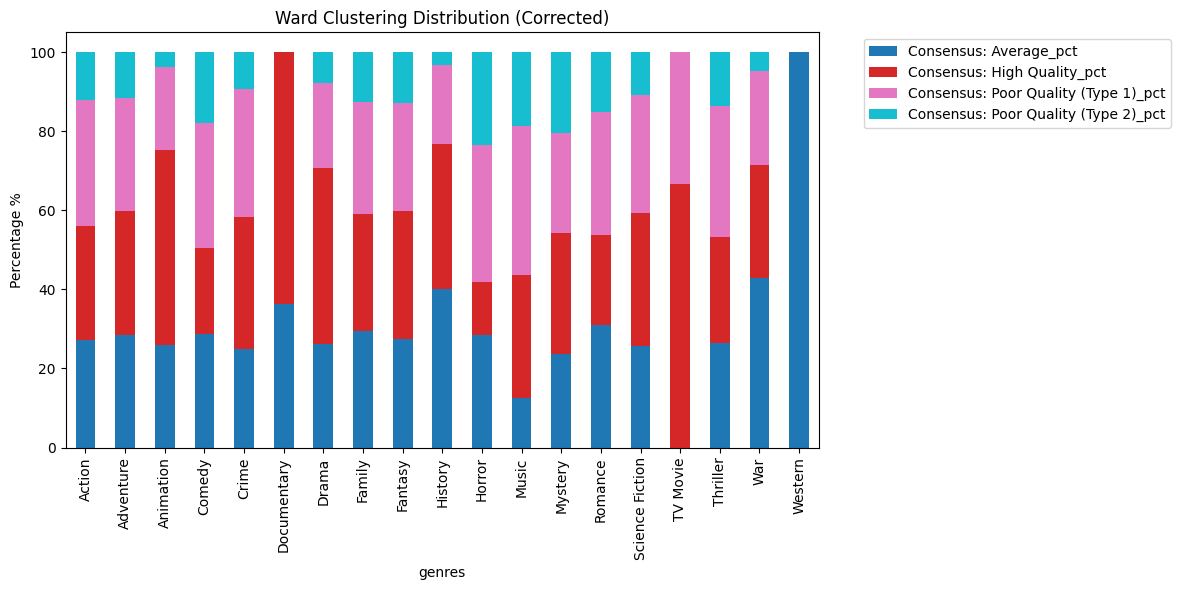

In [518]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

features['genres'] = features['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

ward_exploded = features.explode('genres')

ward_dist = (
    ward_exploded.groupby(['genres', 'cluster_name'])
    .size()
    .unstack(fill_value=0)
)

ward_dist['total'] = ward_dist.sum(axis=1)
for col in ward_dist.columns:
    if col != 'total':
        ward_dist[col+'_pct'] = (ward_dist[col] / ward_dist['total']) * 100

print("Corrected Ward Distribution (Look at the Index!):")
print(ward_dist.head()

cols_to_plot = [c for c in ward_dist.columns if '_pct' in c]
ward_dist[cols_to_plot].plot(
    kind='bar',
    stacked=True,
    figsize=(12,6),
    colormap='tab10'
)

plt.title('Ward Clustering Distribution (Corrected)')
plt.ylabel('Percentage %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()